In [1]:
import os
import cv2
import numpy as np
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt

from transformers import SamModel, SamProcessor

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def to_pil_image(np_img):
    if np_img.dtype != np.uint8:
        if np_img.max() != np_img.min():
            np_img = (255 * (np_img - np_img.min()) / (np_img.max() - np_img.min())).astype(np.uint8)
        else:
            np_img = np_img.astype(np.uint8)
    return Image.fromarray(np_img)

def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice

In [9]:
dataset_path = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir = os.path.join(dataset_path, "seismic")
label_dir   = os.path.join(dataset_path, "label")
all_files = sorted(os.listdir(seismic_dir))
val_files = all_files[:10]

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [34]:
def display_four_images(image, gt_mask, pred_mask, threshold=0.5):
    """
    Отображает 4 изображения:
      1. Исходное изображение.
      2. Исходное изображение с отмеченной случайной точкой (из ground truth маски).
      3. Ground truth маску (в оттенках серого).
      4. Предсказанную маску (в оттенках серого).
      
    Args:
      image: PIL.Image (RGB).
      gt_mask: 2D numpy array с ground truth маской.
      pred_mask: 2D numpy array с предсказанной моделью маской.
      threshold: порог для определения положительных пикселей.
    """
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image.copy()
    
    pos_indices = np.argwhere(gt_mask > threshold)
    if len(pos_indices) == 0:
        h, w = gt_mask.shape
        point = [h // 2, w // 2]
    else:
        point = random.choice(pos_indices)  # (row, col)
    
    # Построение 4-х изображений
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Исходное изображение
    axes[0].imshow(img_np)
    axes[0].set_title("Исходное")
    axes[0].axis("off")
    
    # 2. Исходное изображение с отмеченной точкой
    axes[1].imshow(img_np)
    axes[1].scatter(point[1], point[0], color="green", marker="o", s=100)
    axes[1].set_title("С точкой (ground truth)")
    axes[1].axis("off")
    
    # 3. Ground truth маска
    axes[2].imshow(gt_mask, cmap="gray")
    axes[2].set_title("Ground Truth Маска")
    axes[2].axis("off")
    
    # 4. Предсказанная маска
    axes[3].imshow(pred_mask, cmap="gray")
    axes[3].set_title("Предсказанная Маска")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()


/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


File: 0.dat, IoU: 0.0000, Dice: 0.0000


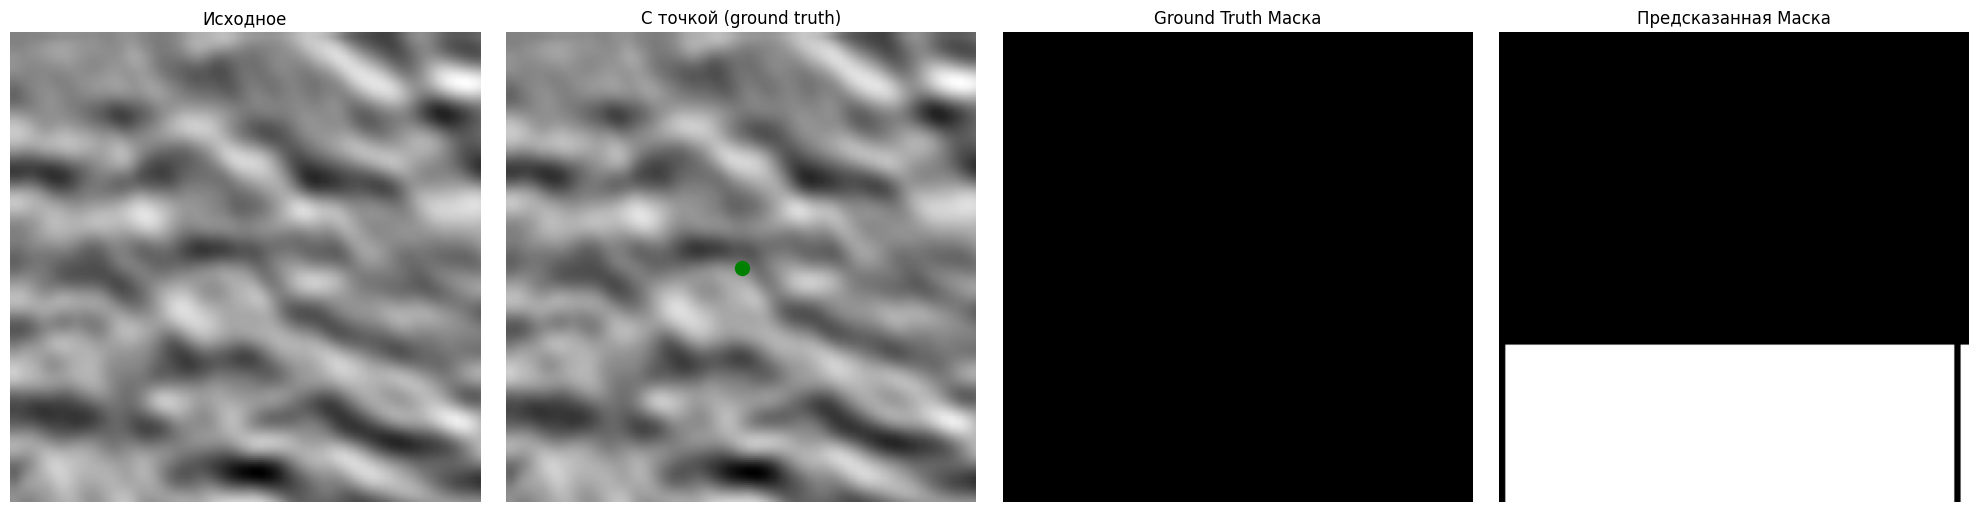

File: 1.dat, IoU: 0.0000, Dice: 0.0000


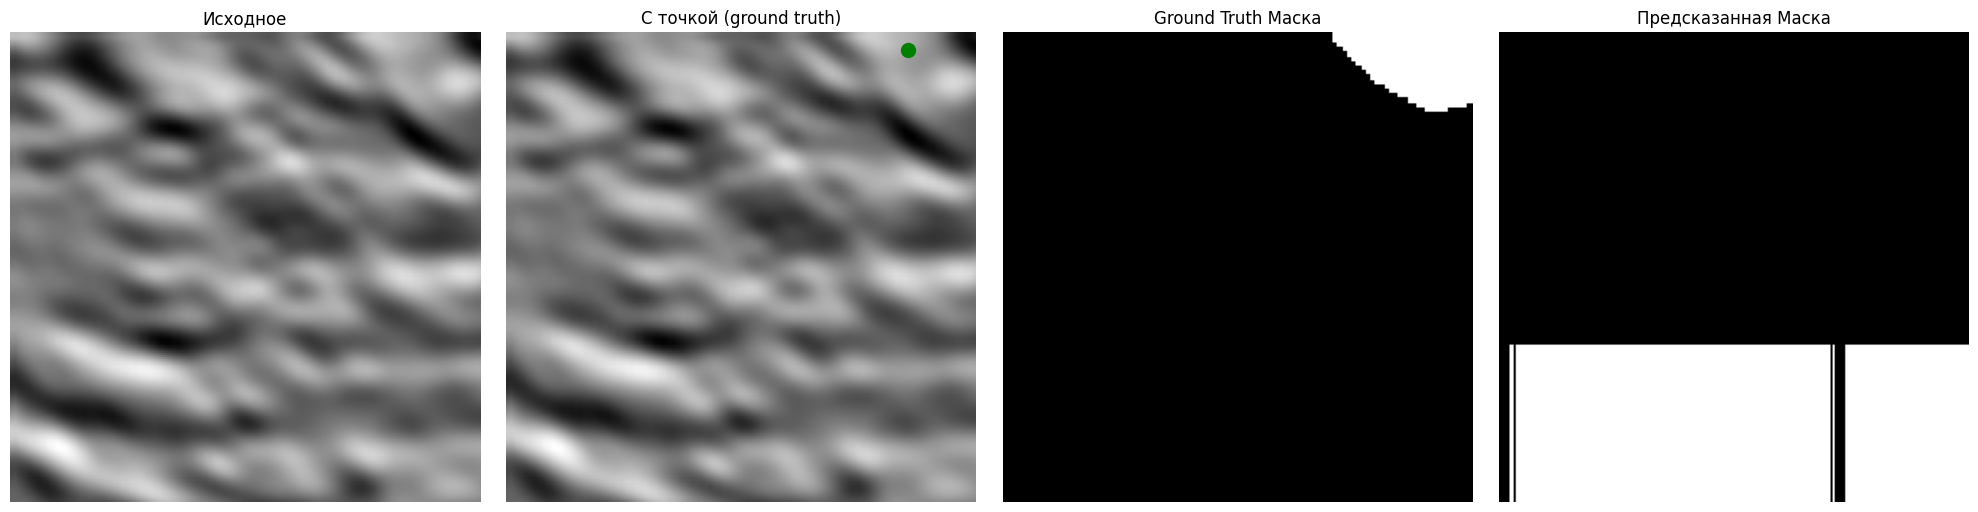

File: 10.dat, IoU: 0.5785, Dice: 0.7330


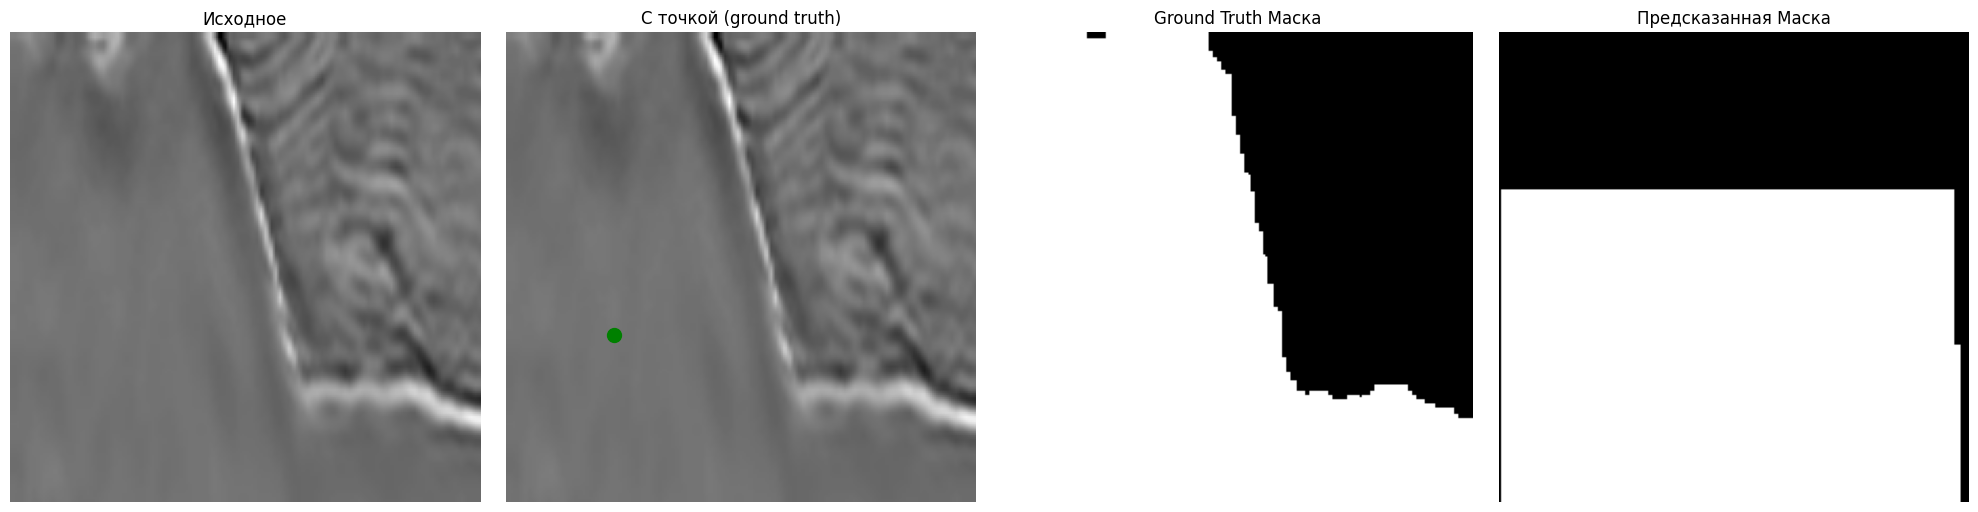

File: 100.dat, IoU: 1.0000, Dice: 1.0000


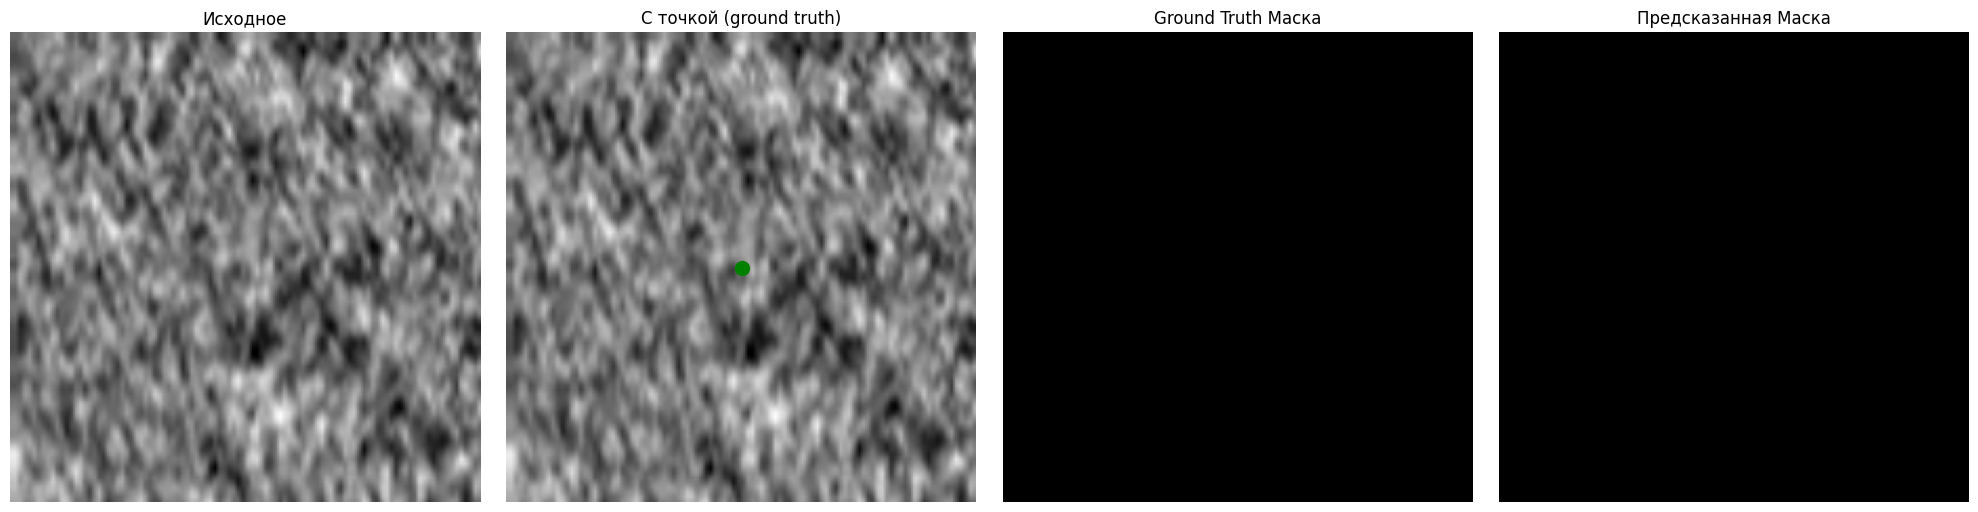

File: 1000.dat, IoU: 0.8951, Dice: 0.9446


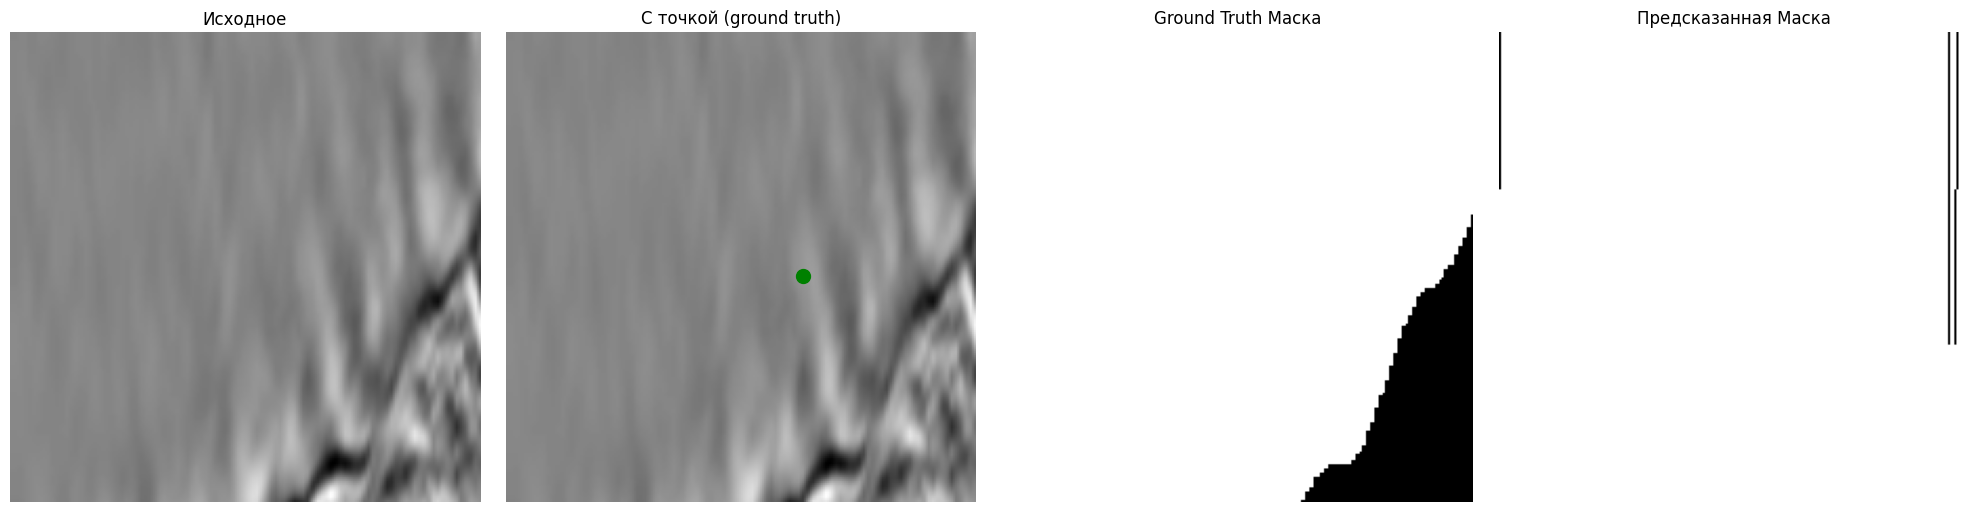

File: 1001.dat, IoU: 0.0380, Dice: 0.0732


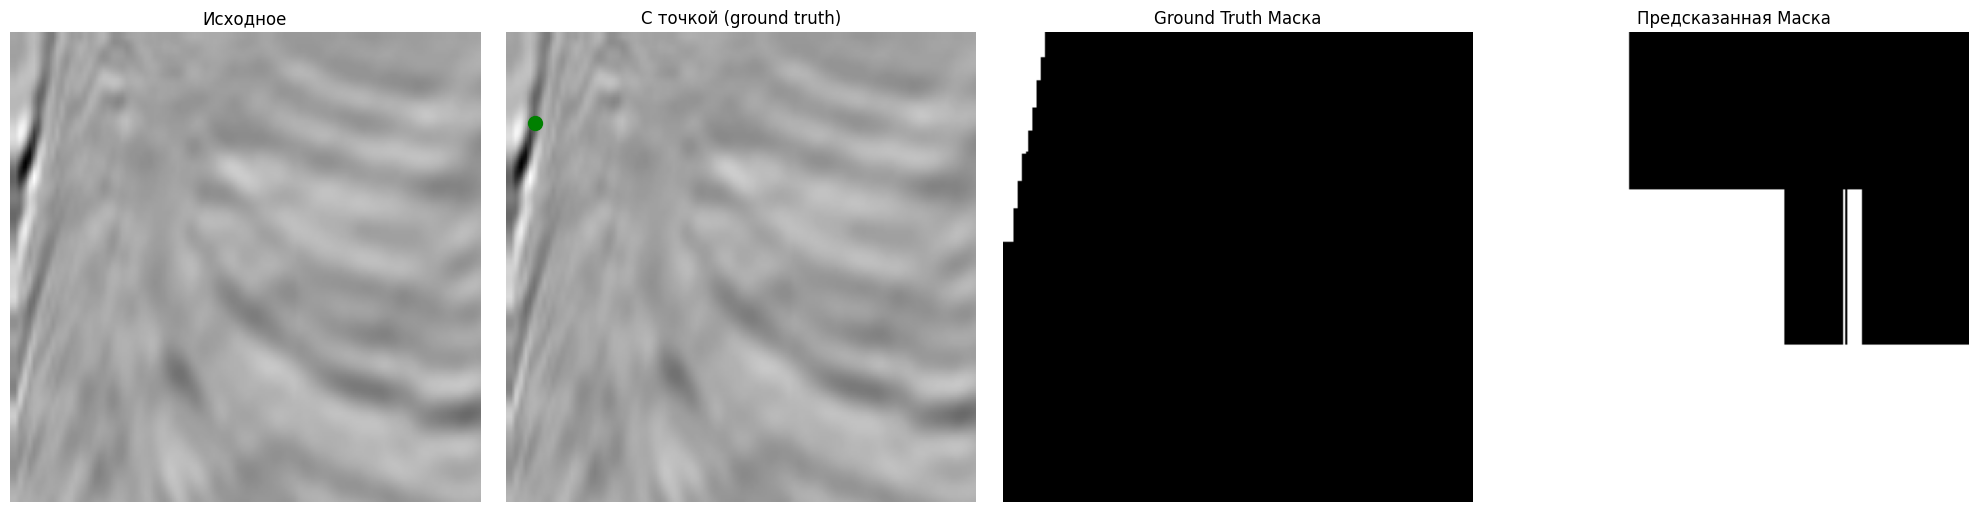

File: 1002.dat, IoU: 0.5337, Dice: 0.6960


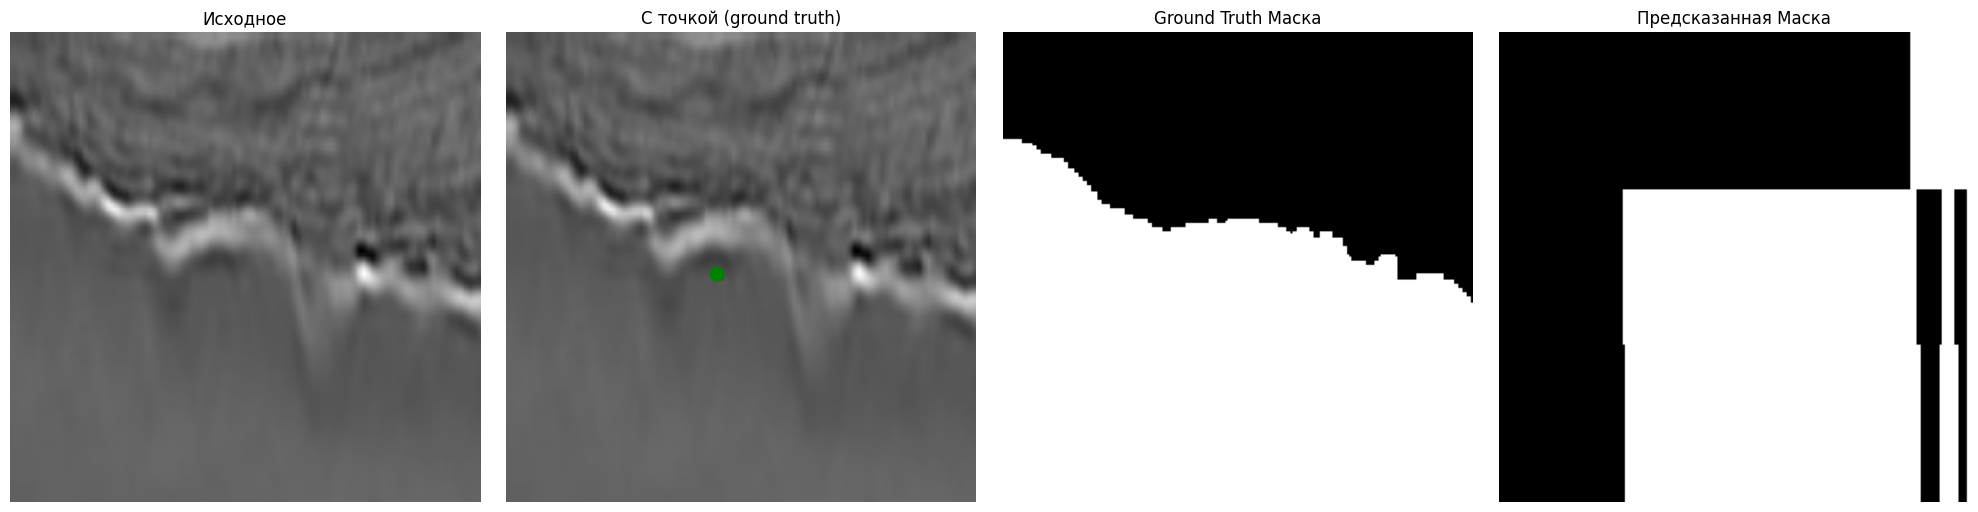

File: 1003.dat, IoU: 0.3524, Dice: 0.5211


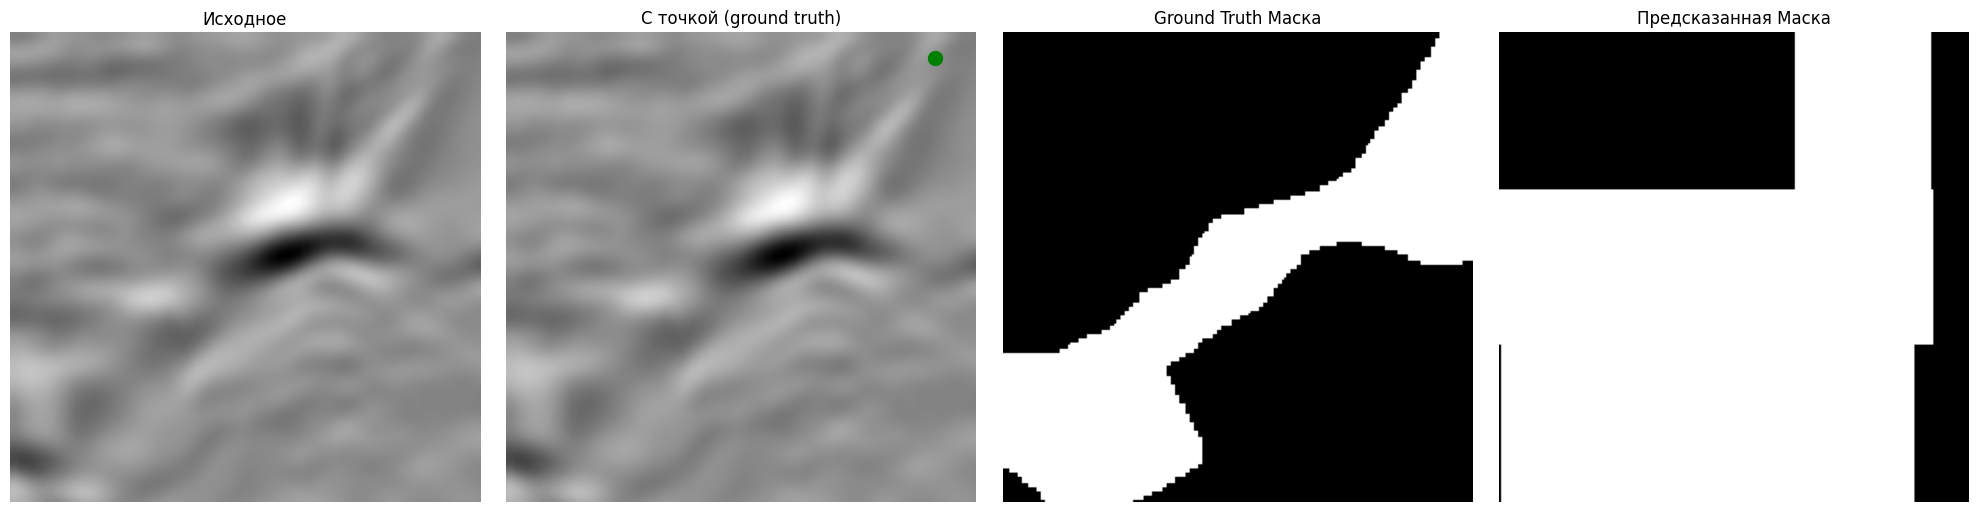

File: 1004.dat, IoU: 0.3192, Dice: 0.4839


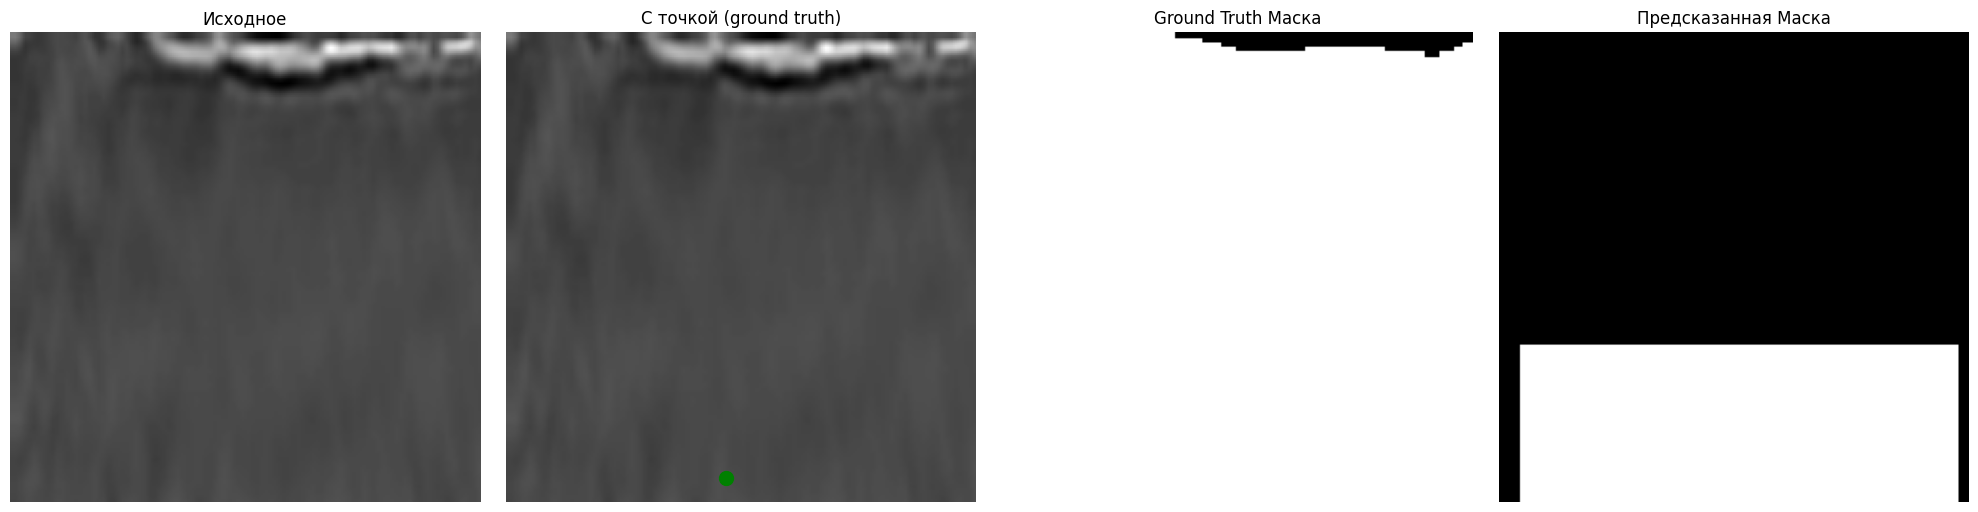

File: 1005.dat, IoU: 0.0987, Dice: 0.1796


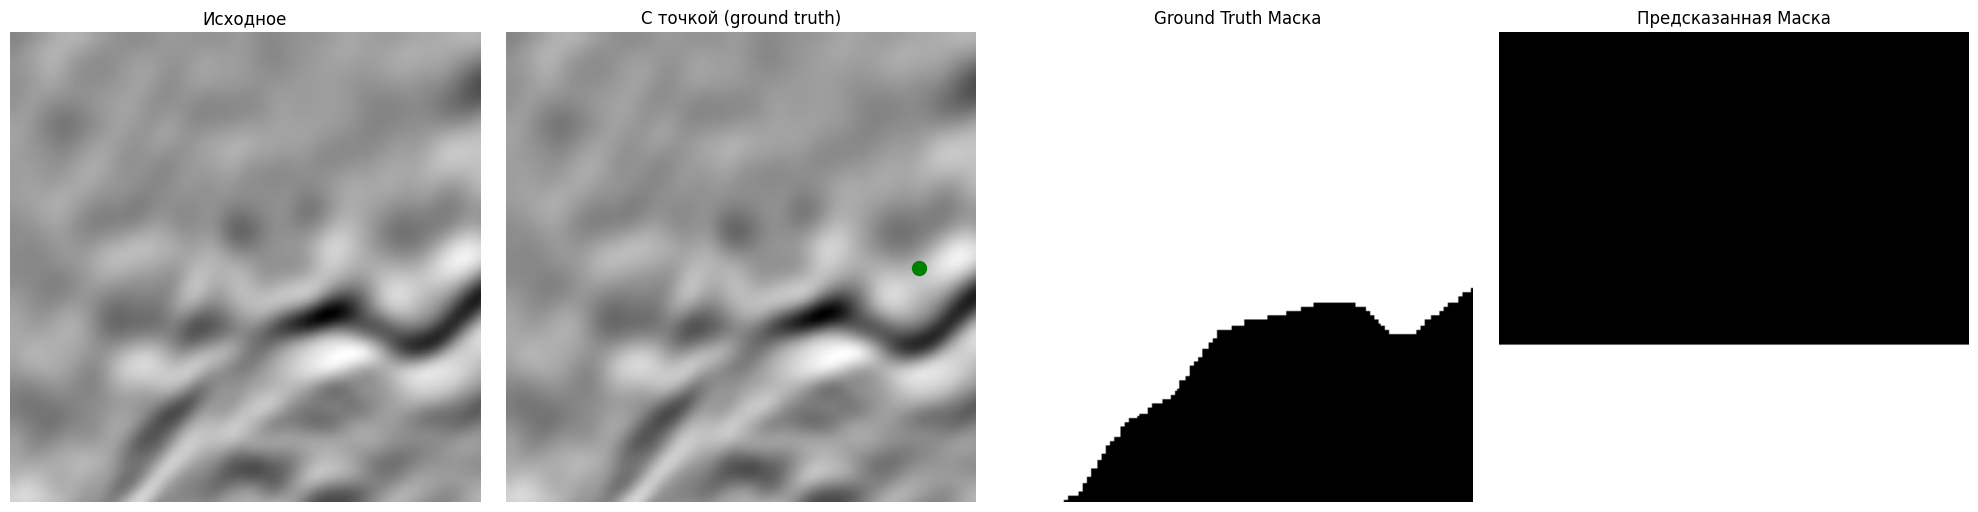

In [35]:
ious = []
dices = []

for filename in val_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)  # Предполагается совпадение имён

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    # Если изображение одноканальное, создаём 3-канальное
    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    pil_image = to_pil_image(seismic_img).convert("RGB")

    # ---------------------------
    # Предсказание маски моделью SAM
    # ---------------------------
    # 1. Вычисление эмбеддингов изображения
    emb_inputs = processor(pil_image, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(emb_inputs["pixel_values"])
    
    # 2. Подготовка prompt: выбираем случайную точку из ground truth маски
    pos_indices = np.argwhere(label > 0)
    if len(pos_indices) > 0:
        chosen_idx = random.choice(pos_indices)
        # SAM ожидает координаты (x, y) = (столбец, строка)
        prompt_point = [[float(chosen_idx[1]), float(chosen_idx[0])]]
    else:
        h, w = label.shape
        prompt_point = [[w / 2.0, h / 2.0]]
    input_points = [prompt_point]

    # 3. Подготовка входных данных с prompt
    inputs = processor(pil_image, input_points=input_points, return_tensors="pt").to(device)
    inputs.pop("pixel_values", None)  # удаляем, чтобы заменить эмбеддингами
    inputs.update({"image_embeddings": image_embeddings})

    # 4. Инференс модели
    with torch.no_grad():
        outputs = model(**inputs)

    # 5. Постобработка предсказанных масок
    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )
    if len(masks) > 0 and len(masks[0]) > 0:
        pred_mask = masks[0][0]
        if isinstance(pred_mask, torch.Tensor):
            pred_mask = pred_mask.cpu().numpy()
        # Выводим оригинальную форму для отладки
        # print("Оригинальная форма pred_mask:", pred_mask.shape)
        pred_mask = np.squeeze(pred_mask)
        # Если после squeeze осталась 3D маска (например, (H, W, C)), берем первый канал.
        if pred_mask.ndim == 3 and pred_mask.shape[2] > 1:
            pred_mask = pred_mask[..., 0]
    else:
        pred_mask = np.zeros(label.shape, dtype=np.uint8)
    
    # Если форма предсказанной маски не совпадает с формой label, приводим её к нужному размеру.
    if pred_mask.shape != label.shape:
        pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))
    
    # Вычисление метрик
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)
    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # ---------------------------
    # Отображение 4 изображений: исходное, с точкой, с overlay и маска.
    # ---------------------------
    display_four_images(pil_image, label, pred_mask)

In [36]:
sum(dices)/len(dices)

np.float64(0.4631475458107965)

In [40]:
sum(dices)/len(dices)

np.float64(0.38722756859448393)

File: 0.dat, IoU: 0.0000, Dice: 0.0000


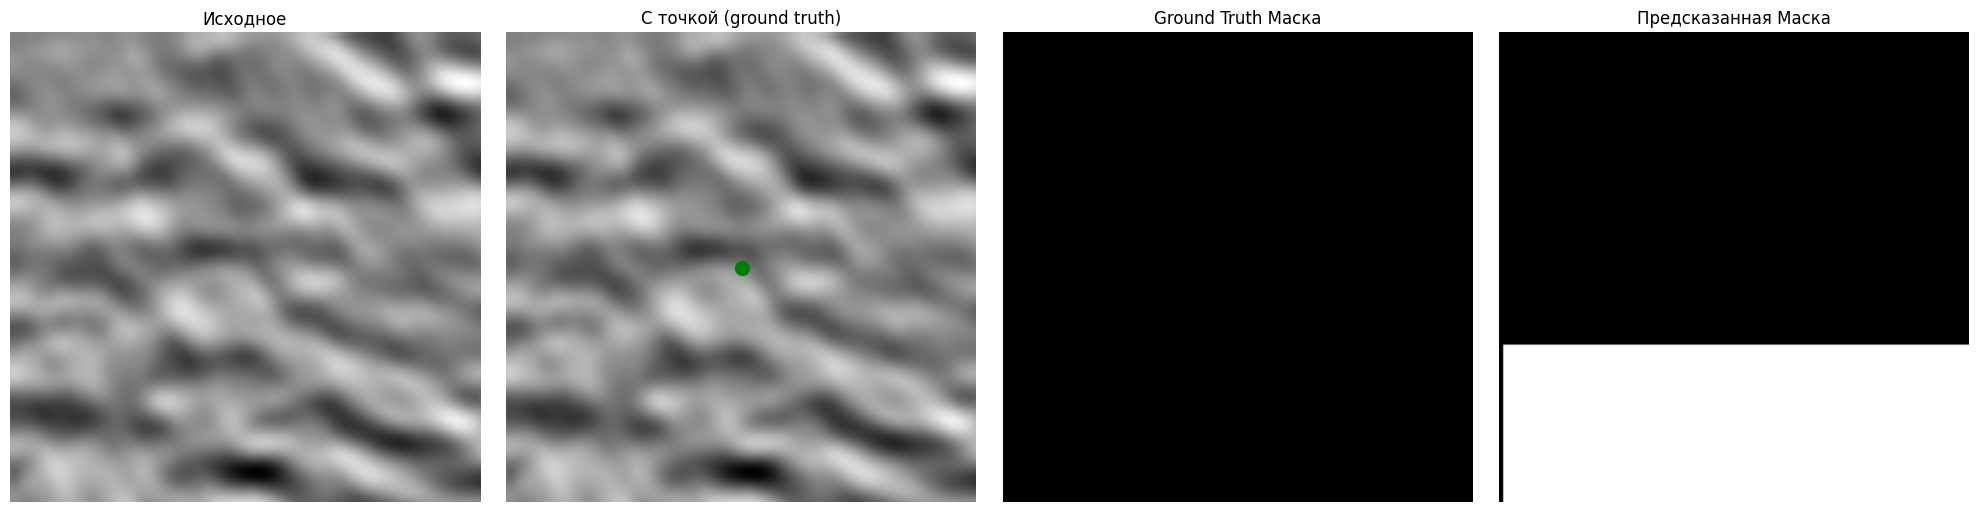

File: 1.dat, IoU: 0.0000, Dice: 0.0000


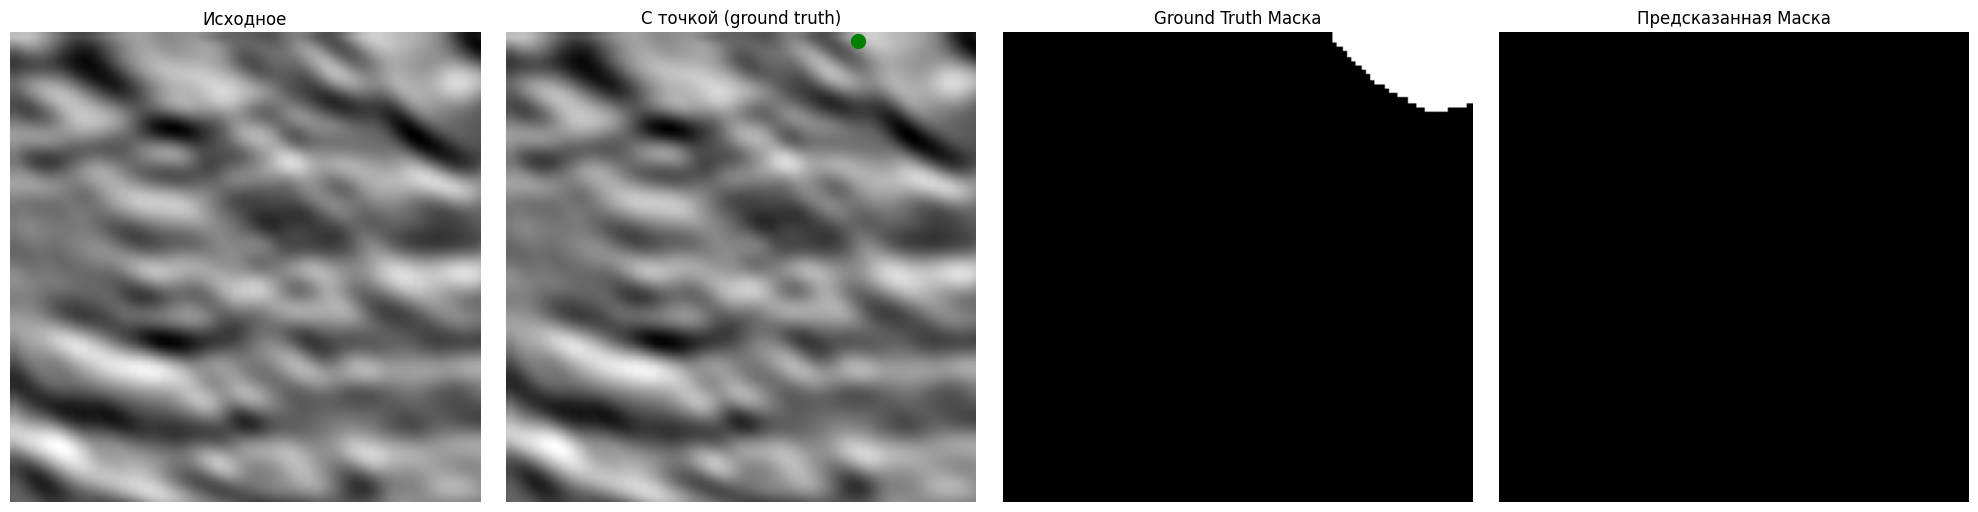

File: 10.dat, IoU: 0.5769, Dice: 0.7317


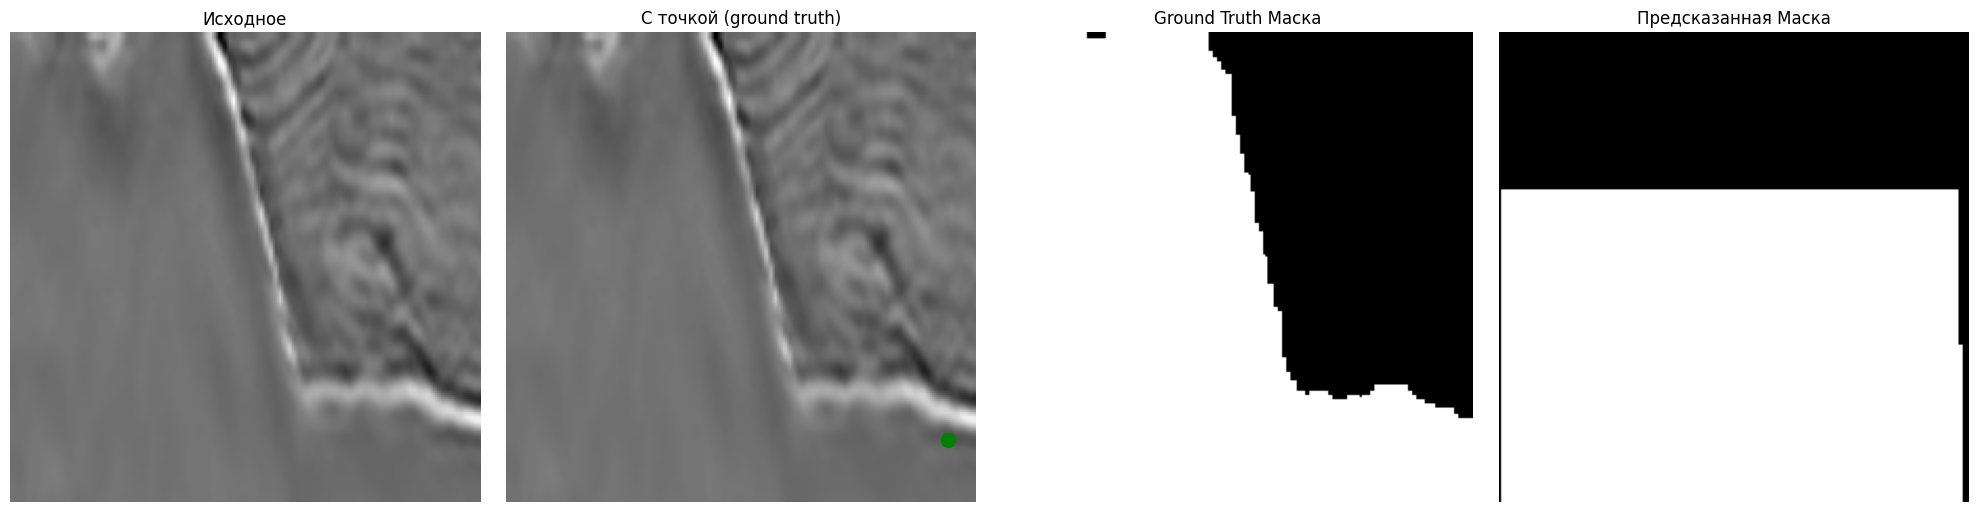

File: 100.dat, IoU: 1.0000, Dice: 1.0000


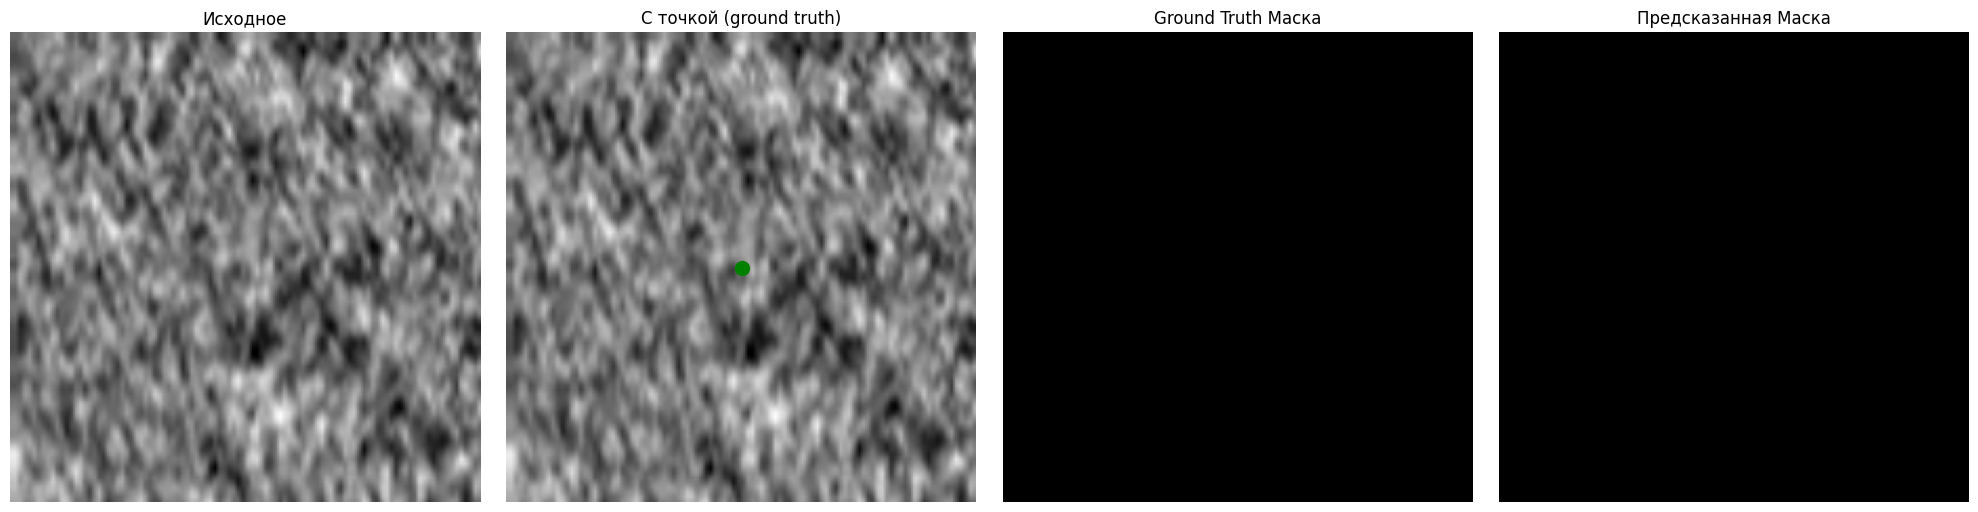

File: 1000.dat, IoU: 0.8834, Dice: 0.9381


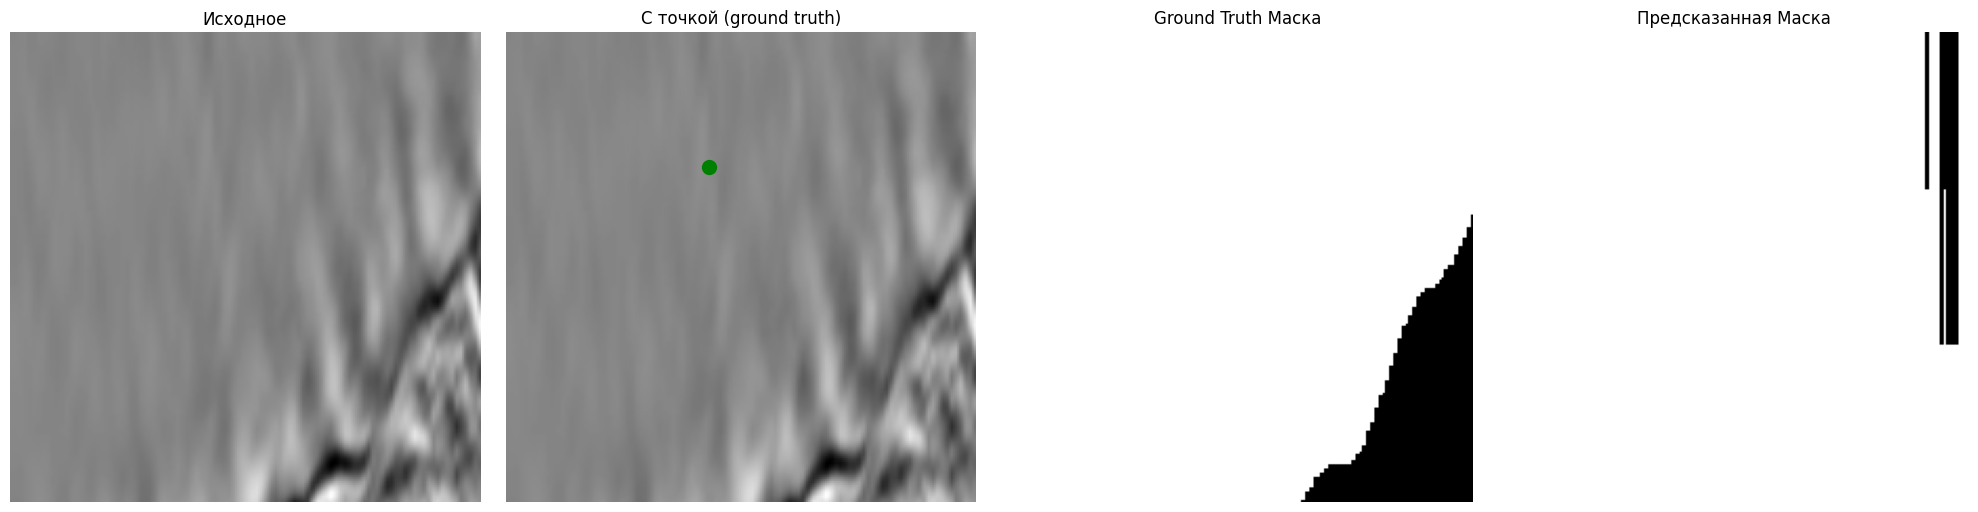

File: 1001.dat, IoU: 0.0406, Dice: 0.0780


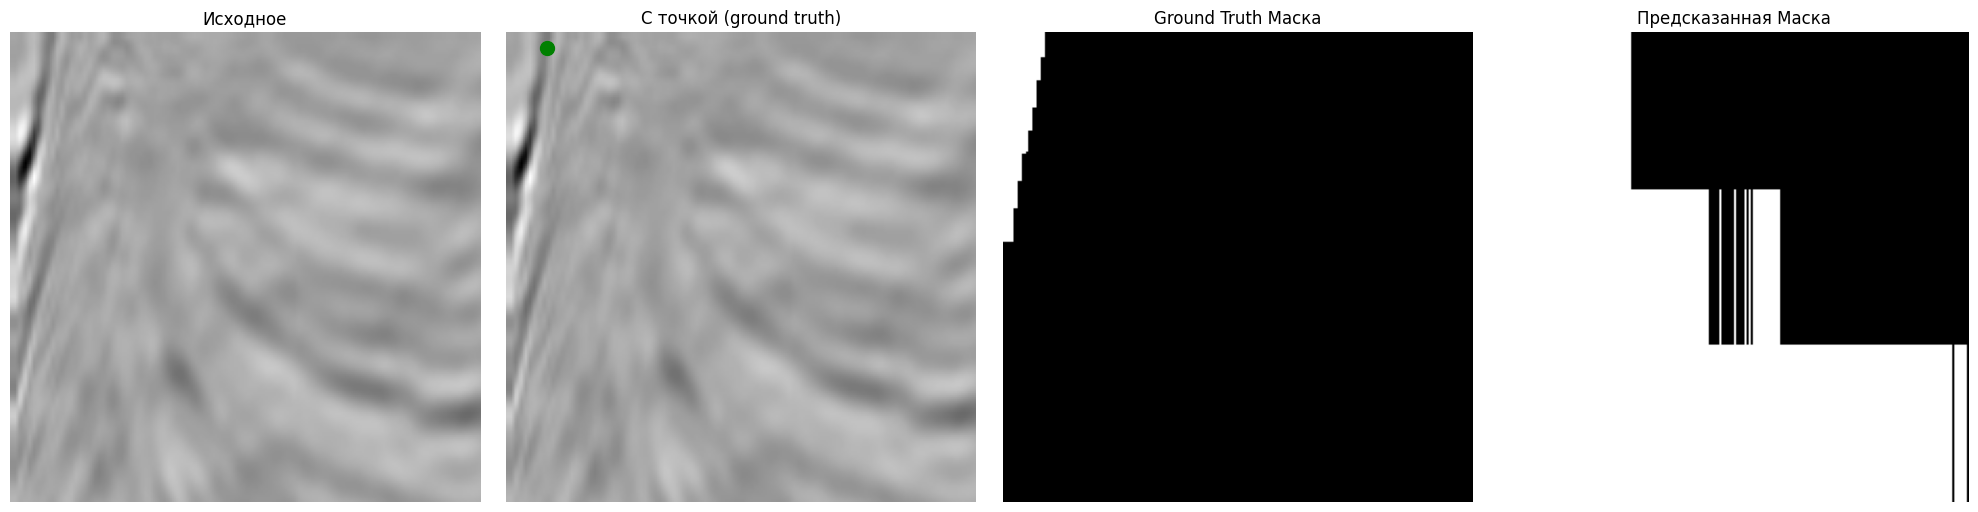

File: 1002.dat, IoU: 0.3148, Dice: 0.4789


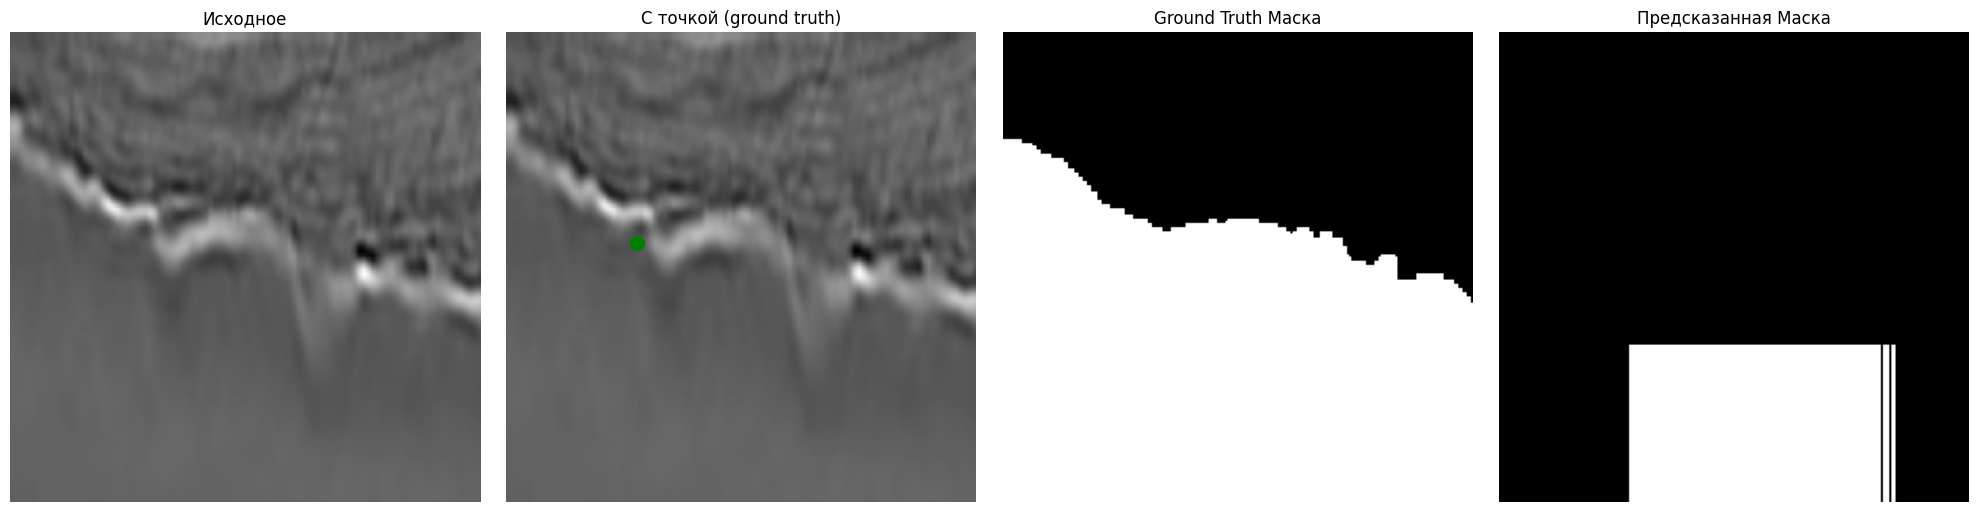

File: 1003.dat, IoU: 0.3059, Dice: 0.4685


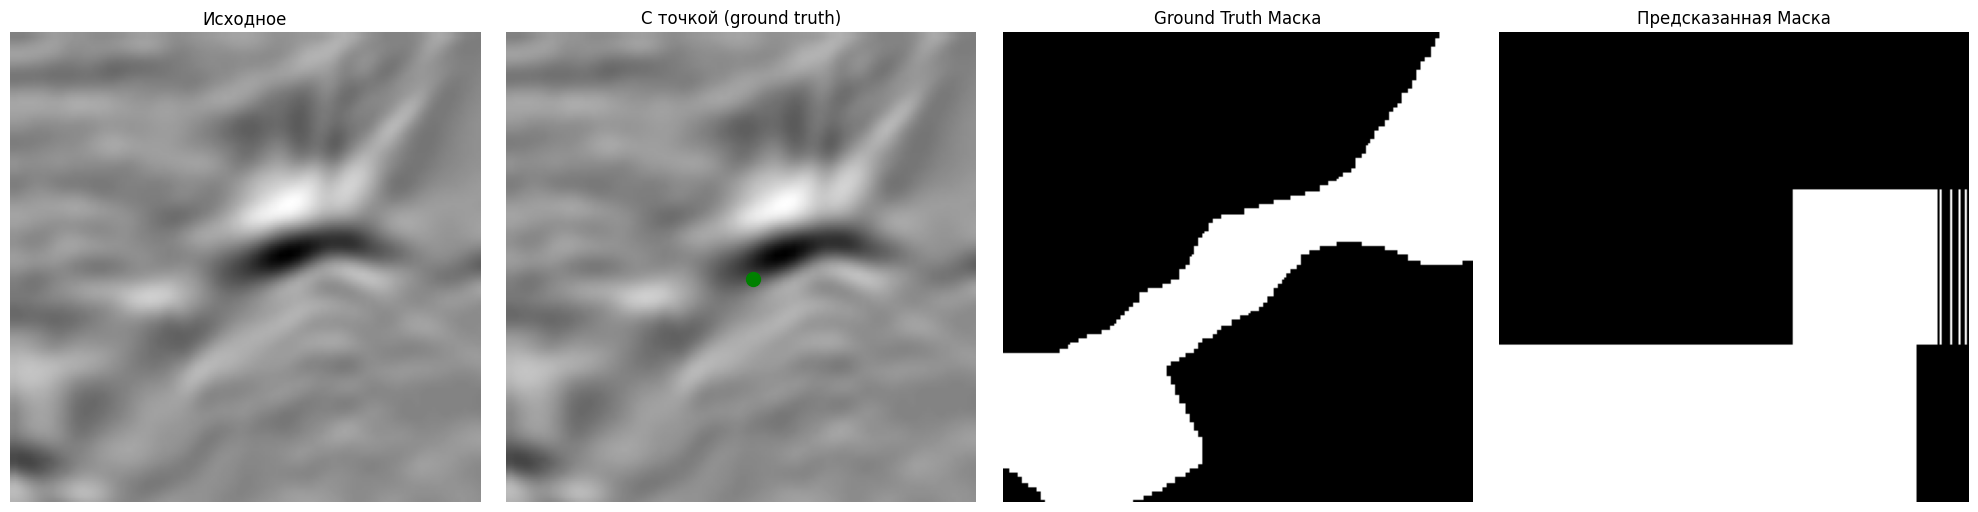

File: 1004.dat, IoU: 0.0000, Dice: 0.0000


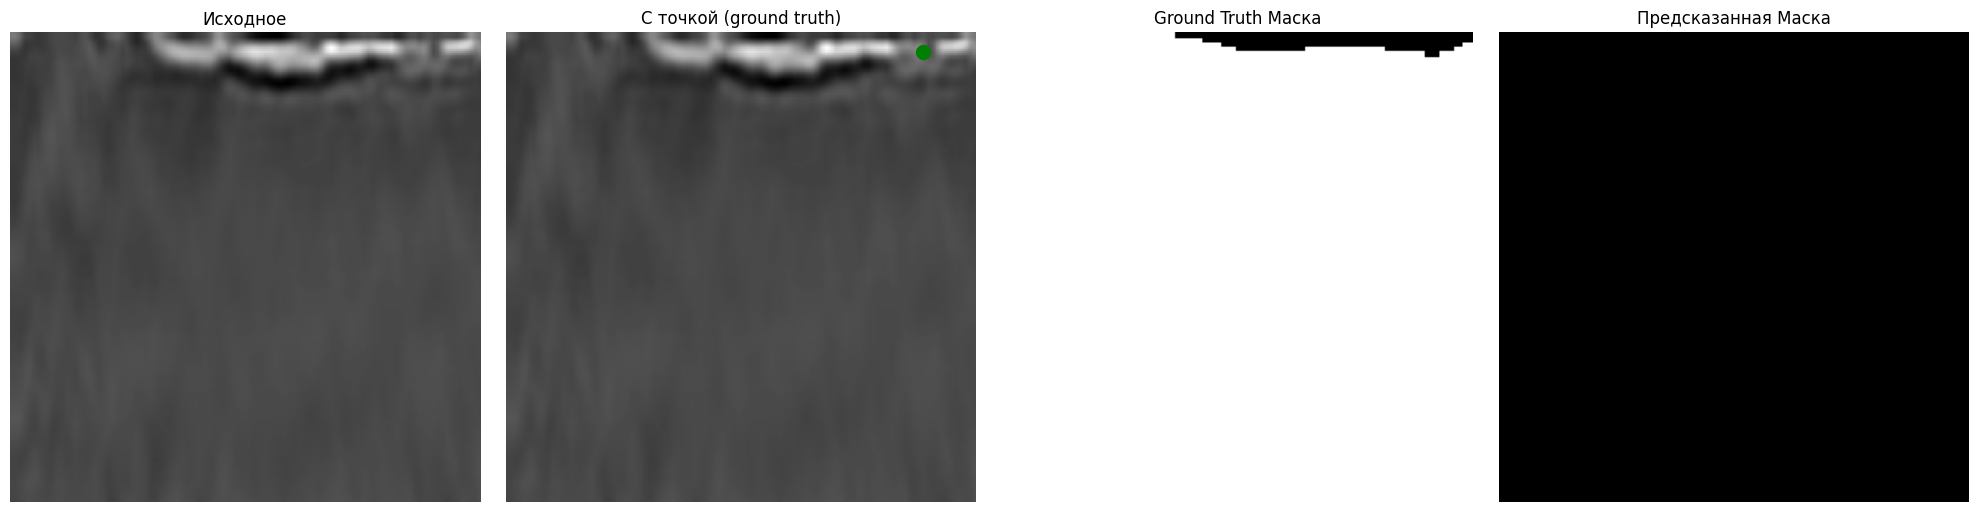

File: 1005.dat, IoU: 0.0971, Dice: 0.1771


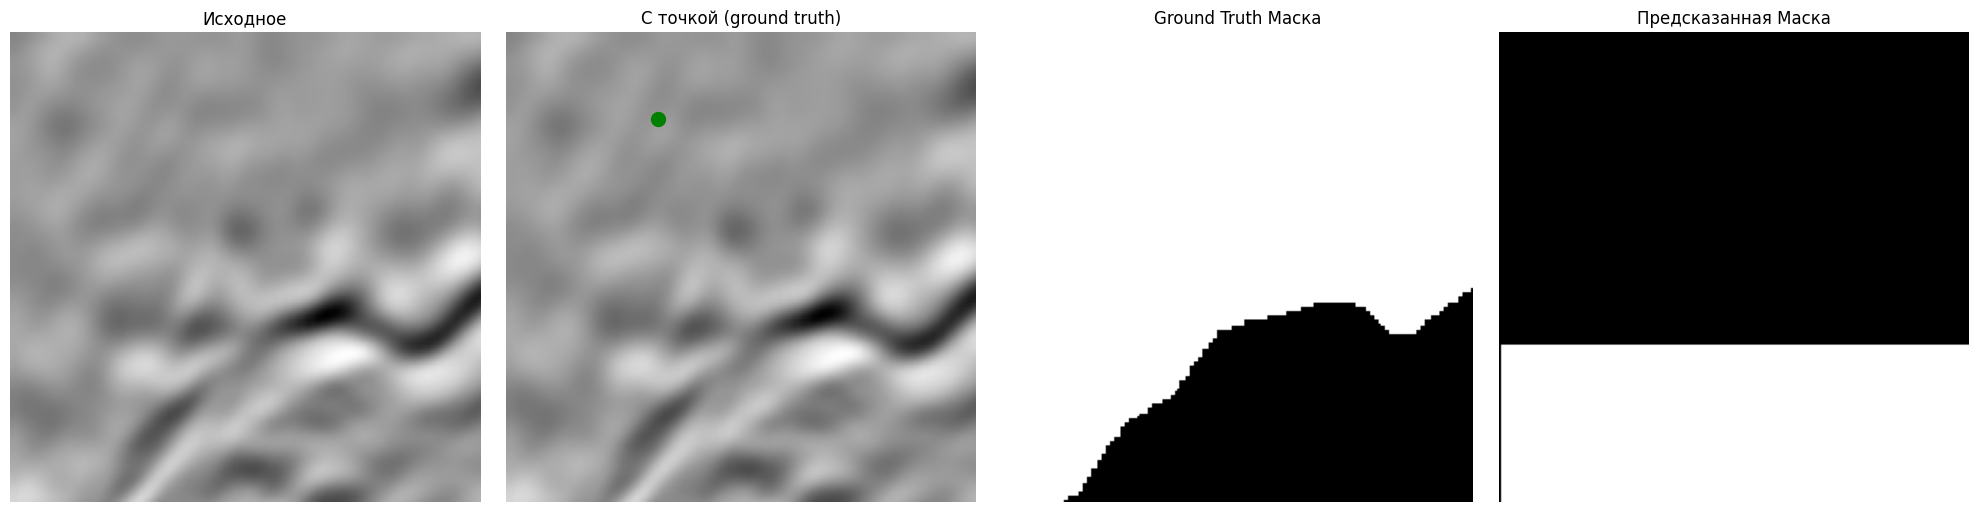

In [39]:
ious = []
dices = []

for filename in val_files:
    seismic_path = os.path.join(seismic_dir, filename)
    label_path   = os.path.join(label_dir, filename)

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    # Если изображение одноканальное, делаем 3 канала
    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    # Преобразуем в PIL
    pil_image = to_pil_image(seismic_img).convert("RGB")

    # 1. Эмбеддинги
    emb_inputs = processor(pil_image, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(emb_inputs["pixel_values"])
    
    # 2. Формируем две точки: позитивную и негативную
    pos_indices = np.argwhere(label > 0)
    neg_indices = np.argwhere(label == 0)
    
    # Если нет позитивных, fallback
    if len(pos_indices) == 0:
        h, w = label.shape
        pos_pt = [w / 2.0, h / 2.0]  # x, y
    else:
        chosen_pos = random.choice(pos_indices)  # (row, col)
        pos_pt = [float(chosen_pos[1]), float(chosen_pos[0])]  # (x, y)

    # Если нет негативных, fallback
    if len(neg_indices) == 0:
        h, w = label.shape
        neg_pt = [w / 4.0, h / 4.0]  # x, y
    else:
        chosen_neg = random.choice(neg_indices)
        neg_pt = [float(chosen_neg[1]), float(chosen_neg[0])]  # (x, y)
    
    # input_points: [ [ [x1,y1], [x2,y2] ] ]
    # input_labels: [ [ 1, 0 ] ]
    prompt_points = [[pos_pt, neg_pt]]
    prompt_labels = [[1, 0]]

    # 3. Подготовка входа
    inputs = processor(
        pil_image,
        input_points=prompt_points,
        input_labels=prompt_labels,
        return_tensors="pt"
    ).to(device)
    inputs.pop("pixel_values", None)
    inputs.update({"image_embeddings": image_embeddings})

    # 4. Инференс
    with torch.no_grad():
        outputs = model(**inputs)

    # 5. Постобработка
    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )
    if len(masks) > 0 and len(masks[0]) > 0:
        pred_mask = masks[0][0]
        if isinstance(pred_mask, torch.Tensor):
            pred_mask = pred_mask.cpu().numpy()
        pred_mask = np.squeeze(pred_mask)
        if pred_mask.ndim == 3 and pred_mask.shape[2] > 1:
            pred_mask = pred_mask[..., 0]
    else:
        pred_mask = np.zeros(label.shape, dtype=np.uint8)

    # Приводим форму к label.shape, если нужно
    if pred_mask.shape != label.shape:
        pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))

    # Метрики
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)
    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # Отображаем
    display_four_images(pil_image, label, pred_mask)